In [3]:
from __future__ import print_function
import numpy as np
import json
import glob 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
recipes = []
path = 'jsons\chunk*.json'   
files=glob.glob(path)   
for file in files: 
    with open(file) as f:
        for line in f:
            recipes.append(json.loads(line))

# Statistics

### Dataset Basic Information

In [5]:
print("There are {} recipes in this dataset".format(len(recipes)))

There are 1020 recipes in this dataset


In [6]:
print(type(recipes[0]))

<type 'dict'>


In [7]:
print(recipes[0].keys())

[u'rating', u'code', u'name', u'servings', u'calories', u'reviews', u'num_reviews', u'tag', u'steps', u'time', u'tips', u'ing', u'desc']


### Most Popular Ingredients

In [8]:
from collections import Counter

In [9]:
all_ings = [ing for ings in [recipe['ing'] for recipe in recipes] for ing in ings]
count = Counter(all_ings)
top_n =  count.most_common(10)

In [10]:
print ("The top 10 most commonly used ingredients are: \n\n{}".format
       ("\n".join(str(ing) for ing in top_n)))

The top 10 most commonly used ingredients are: 

(u'1/2 teaspoon salt', 123)
(u'1 teaspoon salt', 113)
(u'2 eggs', 100)
(u'1 teaspoon vanilla extract', 92)
(u'salt and pepper to taste', 88)
(u'1 egg', 80)
(u'1/4 teaspoon salt', 71)
(u'1 teaspoon baking soda', 65)
(u'1 cup white sugar', 64)
(u'2 cups all-purpose flour', 46)


* Potential Challenge/To Do: Format ingredients to separate quantity/actual ingredient

### Rating Distribution

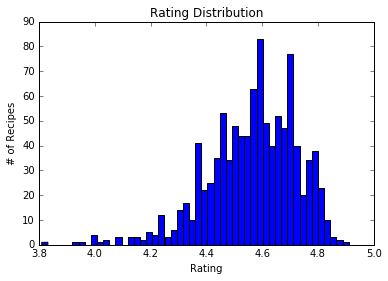

In [11]:
plt.hist([y['rating'] for y in recipes],bins= 50)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("# of Recipes")
plt.show()

* Potential Challenge/To Do: It seems as though our dataset only consists of recipes that already have high ratings. We need to expand our dataset in order to avoid selection bias.

### Cooking Time Distribution

In [17]:
import math

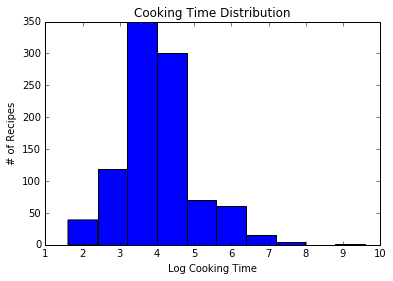

In [21]:
plt.hist([math.log(y['time']) for y in recipes if (y['time'] != -1)])
plt.title("Cooking Time Distribution")
plt.xlabel("Log Cooking Time")
plt.ylabel("# of Recipes")
plt.show()

* Probably a bug in the code thats encoding the times inconsistently. Discarded values over 1000 for now but still not making sense. Should take this plot out.

### Number of Reviews Distribution

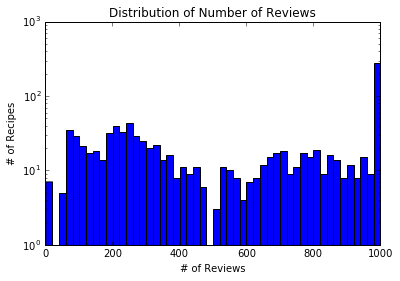

In [279]:
plt.hist([len(y['reviews']) for y in recipes], bins = 50, log = True)
plt.title("Distribution of Number of Reviews")
plt.xlabel("# of Reviews")
plt.ylabel("# of Recipes")
plt.show()

* The cutoff for maximum reviews seems to be 1000
* Why is the bin for 500 reviews empty...?
* Number of reviews seem pretty evenly distributed throughout the recipes. 